In [1]:
import pandas as pd
import random
import math
import operator
import numpy as np
import scipy as sc
from IPython.display import display, HTML

In [2]:
# Statsmodel
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf

# Modelling
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metric
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

# Resampling
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score


/Users/ando/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from matplotlib import gridspec

%matplotlib inline
plt.style.use('smandry')

In [188]:
# Extend linear_model.LinearRegression to calculate stats
class LinearRegression(linear_model.LinearRegression):
    def __init__(self,*args,**kwargs):
        """
        Linear Regression with Stats output
        """
        super(LinearRegression,self).__init__(*args,**kwargs)

    def fit_stats(self,X,y):
        self.fit(X,y)
        self.params = np.append(self.intercept_,self.coef_)
        predictions = self.predict(X)
        newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))        
        MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
        self.MSE = MSE
        variance = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
        self.StdErr = np.sqrt(variance)
        self.tValues = self.params/self.StdErr
        self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(len(newX)-1))) for i in self.tValues]
        self.confInt = [self.params-1.95996398*self.StdErr, self.params+1.95996398*self.StdErr]
        
        myDF3 = pd.DataFrame(index=newX.columns)
        myDF3["Coefs"],myDF3["StdErr"],myDF3["tValues"],myDF3["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
        myDF3["[0.025"] = self.confInt[0]
        myDF3["0.0975]"] = self.confInt[1]
        self.results = myDF3
        
def cross_val(algr, X, y, nfold=10):
    kfold = KFold(n_splits=nfold) 
    mse = [] 
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = algr.fit(X_train, y_train.ravel())
        ypred = model.predict(X_test)
        mse.append(mean_squared_error(y_test, ypred))
    return np.asarray(mse)

In [6]:
# Loading Auto data
auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [81]:
# Add quadratic term horsepower**2
reg = LinearRegression()
mse_poly = np.zeros((10,10))
poly = np.arange(10)+1

for i in range(10):
    Xtr, Xtes, ytrain, ytest = train_test_split(auto[['horsepower']], auto.mpg, test_size=0.5)
    Xtrain = Xtr.values
    Xtest = Xtes.values
    for k in range(10):
        Xtrain = np.hstack((Xtrain, (Xtrain[:,0]**(k+1)).reshape(-1,1)))
        Xtest = np.hstack((Xtest, (Xtest[:,0]**(k+1)).reshape(-1,1)))
        reg.fit(Xtrain, ytrain)
        pred = reg.predict(Xtest)
        mse_poly[k,i] = mean_squared_error(ytest, pred)


(16, 30)

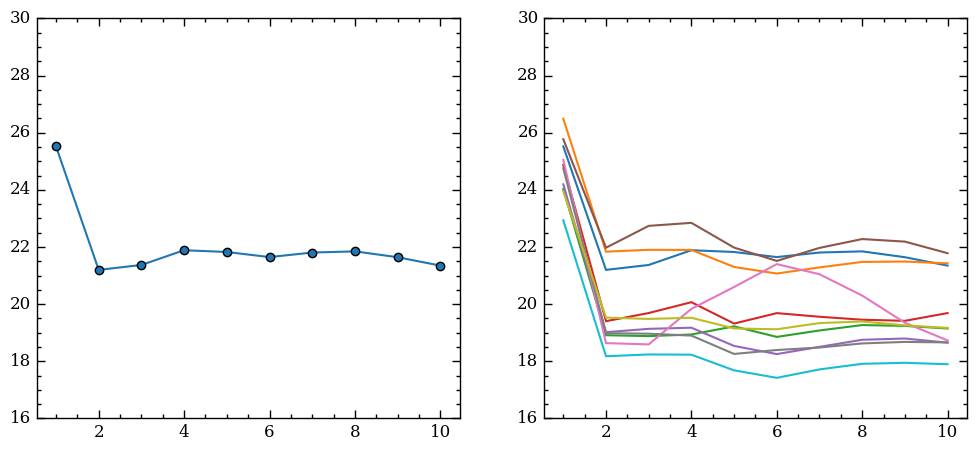

In [91]:
# Plot figure 5.2
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.plot(poly, mse_poly[:,0],'o-')
ax1.set_ylim([16,30])
for i in range(10):
    ax2.plot(poly, mse_poly[:,i],'-')
ax2.set_ylim([16,30])

# Leave one out Cross validation

In [126]:
# Leave one out cross validation is a special case of Kfold validation with n_split=len(X). scoring=neg_mean_squared_error 
NewX = auto[['horsepower']].values
reg = linear_model.LinearRegression()
loo_mse = np.zeros(10)
for i in range(10):
    if i==0:
        loo_mse[i] = -cross_val_score(reg, NewX, auto.mpg.values, cv=len(auto), scoring='neg_mean_squared_error').mean() 
    else:
        NewX = np.hstack((NewX, (NewX[:,0]**(i+1)).reshape(-1,1)))
        loo_mse[i] = -cross_val_score(reg, NewX, auto.mpg.values, cv=len(auto), scoring='neg_mean_squared_error').mean()    


In [183]:
# 10-fold cross validation was run 9 times, use shuffle=True to get different fold each run 
reg = linear_model.LinearRegression()
k10_mse = np.zeros((9, 10))
for j in range(9):
    NewX = auto[['horsepower']].values
    for i in range(10):
        if i==0:
            kf_10 = KFold(n_splits=10,shuffle=True)        
            k10_mse[j,i] = -cross_val_score(reg, NewX, auto.mpg.values, cv=kf_10, scoring='neg_mean_squared_error').mean() 
        else:
            kf_10 = KFold(n_splits=10,shuffle=True)
            NewX = np.hstack((NewX, (NewX[:,0]**(i+1)).reshape(-1,1)))
            k10_mse[j,i] = -cross_val_score(reg, NewX, auto.mpg.values, cv=kf_10, scoring='neg_mean_squared_error').mean()    


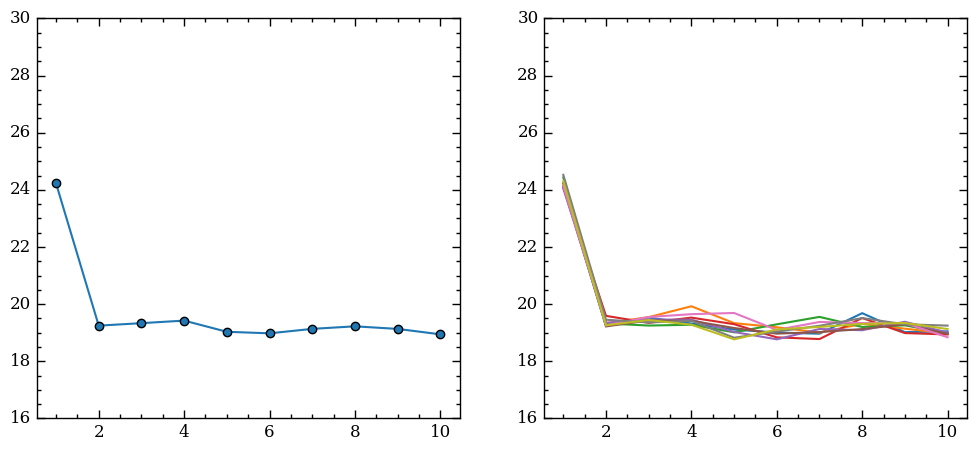

In [185]:
# Plot figure 5.4
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.plot(poly, loo_mse[:],'o-')
ax1.set_ylim([16,30])
for i in range(9):
    ax2.plot(poly, k10_mse[i,:],'-')
ax2.set_ylim([16,30])
plt.show()

# Lab: Resampling

In [215]:
Xtrain, Xtest, ytrain, ytest = train_test_split(auto[['horsepower']], auto.mpg, test_size=0.5, random_state=1)
reg = linear_model.LinearRegression()
reg.fit(Xtrain, ytrain)
ypred = reg.predict(Xtest)
mean_squared_error(ytest, ypred)

#train = auto[['horsepower','mpg']].sample(frac=0.5, random_state=1)
#test = auto.loc[~auto.index.isin(train.index),['horsepower','mpg']]

24.802120620593559

In [212]:
reg.fit(train[['horsepower']], train['mpg'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)